# **The Algonauts Project 2023 Challenge - devkit tutorial**

The quest to understand the nature of human intelligence and engineer more advanced forms of artificial intelligence are becoming increasingly intertwined. The Algonauts Project brings biological and machine intelligence researchers together on a common platform to exchange ideas and advance both fields. The 2023 Challenge focuses on explaining neural visual responses to complex naturalistic scenes.

The Challenge is based on the [Natural Scenes Dataset][nsd] (NSD), a massive dataset of 7T fMRI responses to images of natural scenes coming from the [COCO dataset][coco]. The goal of the Challenge is to promote the development of cutting-edge encoding models which accurately predict (i.e., encode) the fMRI responses to visual input. You can read more about the Challenge in the [website][web] and [paper][paper].

Here we provide the development kit tutorial of the Challenge where you will learn how to:
1. Load and visualize the Challenge fMRI data, functionally different areas of the visual cortex called regions-of-interest (ROIs), and the stimulus images.
2. Build [linearizing encoding models][encoding] using a pretrained [AlexNet][alexnet] architecture, evaluate them and visualize the resulting prediction accuracy (i.e., encoding accuracy).
3. Prepare the predicted brain responses to the test images in the right format for submission to the Challenge leaderboard.

If you want to run this tutorial locally you can download it as a Jupyter Notebook file by selecting (`File --> Download --> Download .ipynb`) from the menu. The running time of the tutorial on [Colab][tutorial_colab] is approximately 1h with GPU.

Please watch [this video][video] for an introduction to the Algonauts Project 2023 Challenge and a walkthrough of this development kit tutorial.

If you experience problems with the code please get in touch with Ale (alessandro.gifford@gmail.com).

[nsd]: https://doi.org/10.1038/s41593-021-00962-x
[coco]: https://cocodataset.org/#home
[web]: http://algonauts.csail.mit.edu
[paper]: https://arxiv.org/abs/2301.03198
[encoding]: https://www.sciencedirect.com/science/article/pii/S1053811910010657
[alexnet]: https://arxiv.org/abs/1404.5997
[tutorial_colab]: https://colab.research.google.com/drive/1bLJGP3bAo_hAOwZPHpiSHKlt97X9xsUw?usp=share_link
[video]: https://youtu.be/KlwSDpxUX6k

# 0 First steps

Note that in sections `1.1 Install and import the necessary Python libraries` and `1.2 Access the tutorial data` you will have to run different code cells based on whether you are running the tutorial on Colab or on Jupyter Notebook. An `if statement` will take care of this. You only need to select `'colab'` or `'jupyter_notebook'` for the `platform` variable below.

In [1]:
platform = 'jupyter_notebook' #@param ['colab', 'jupyter_notebook'] {allow-input: true}

## 0.1 Install and import the necessary Python libraries

### 0.1.1 Install libraries, Google Colab


If you are running the tutorial on Google Colab, you need to install the `nilearn` library using the following code.

In [ ]:
if platform == 'colab':
    !pip install nilearn==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 46.9 MB/s eta 0:00:00


### 0.1.2 Install libraries, Jupyter Notebook


If you are running the tutorial on Jupyter Notebook, you need to install the following libraries on your local machine before running the tutorial: [numpy][numpy], [tqdm][tqdm], [PIL][PIL], [torch][torch], [torchvision][torchvision], [sklearn][sklearn], [scipy][scipy], [nilearn][nilearn], [matplotlib][matplotlib], [jupyter][jupyter].

You can install these libraries into a dedicated [Anaconda] environment. For this, download the  [`environment.yml`][env_file] file, open your terminal in the download directory and type:
```
conda env create -f environment.yml
conda activate algonauts
```
This will create and activate an Anaconda environment with all the required libraries.

If you wish to install the libraries manually, you can find their required versions in the [`environment.yml`][env_file] file.

[numpy]: https://numpy.org/
[tqdm]: https://github.com/tqdm/tqdm
[PIL]: https://python-pillow.org/
[torch]: https://pytorch.org/
[torchvision]: https://pytorch.org/
[sklearn]: https://scikit-learn.org/stable/#
[scipy]: https://scipy.org/
[nilearn]: https://nilearn.github.io/stable/index.html
[matplotlib]: https://matplotlib.org/stable/index.html
[jupyter]: https://jupyter.org/
[anaconda]: https://www.anaconda.com/
[env_file]: https://drive.google.com/file/d/1lLzMK1e3eBmhwZvi0U3gCJRYuOAO8IIF/view?usp=share_link

### 0.1.3 Import the libraries

Once you have installed all necessary libraries, import them with the following code.

In [2]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

## 0.2 Access the tutorial data

### 0.2.1 Access the data on Google Colab


If you are running the tutorial on Google Colab you can use the Challenge data located in a Google Drive public folder called `algonauts_2023_tutorial_data` (fill out [this form][data] to get the folder link). This folder containes the **unzipped** data of each subject. Before running the tutorial code you need to select this folder and choose "Add a shortcut to Drive". This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can read the content after mounting using `drive.mount()`. Finally, edit the `data_dir` variable below with the path on your Drive to the `algonauts_2023_tutorial_data` shortcut folder, and the `parent_submission_dir` variable  with the path on your Drive where you wish to save the predicted test fMRI data for Challenge submission.

[data]: https://docs.google.com/forms/d/e/1FAIpQLSehZkqZOUNk18uTjRTuLj7UYmRGz-OkdsU25AyO3Wm6iAb0VA/viewform?usp=sf_link

In [ ]:
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/algonauts_2023_tutorial_data' #@param {type:"string"}
    parent_submission_dir = '/content/drive/MyDrive/algonauts_2023_challenge_submission' #@param {type:"string"}

Mounted at /content/drive/


### 0.2.2 Access the data on Jupyter Notebook



If you are running the tutorial on Jupyter Notebook you first need to download the Challege data from a public Google Drive folder called `algonauts_2023_challenge_data` (fill out [this form][data] to get the folder link). This folder containes the **zipped** data of each subject. Once the download is complete, unzip each subject's data file by opening your terminal in the download directory and typing:
```
unzip subj0*.zip
```

Then edit the `data_dir` variable below with the path to the parent folder containing the unzipped data of all subjects, and the `parent_submission_dir` variable  with the path where you wish to save the predicted test fMRI data for Challenge submission.

[data]: https://docs.google.com/forms/d/e/1FAIpQLSehZkqZOUNk18uTjRTuLj7UYmRGz-OkdsU25AyO3Wm6iAb0VA/viewform?usp=sf_link

In [3]:
if platform == 'jupyter_notebook':
    # data_dir = '../../../Projects/Datasets/Biomedical/algonauts_2023_challenge_data'
    data_dir = '../../../Projects/Datasets/Biomedical/algonauts_2023_challenge_data'
    parent_submission_dir = '../algonauts_2023_challenge_submission'

## 0.3 Select CPU or GPU

If you want to run the tutorial code on GPU (`'cuda'`), and you are using Google Colab, make sure you select the appropiate runtime from the menu (`Runtime --> Change runtime type --> GPU`). Alternatively you can run the tutorial on CPU (`'cpu'`) (Colab's default).

In [4]:
device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
device = torch.device(device)

In [5]:
print(torch.cuda.is_available())

print(torch.cuda.device_count())

print(torch.cuda.current_device())

print(torch.cuda.device(0))

print(torch.cuda.get_device_name(0))


True
1
0
NVIDIA GeForce RTX 3070 Laptop GPU


# 1 Load and visualize the Challenge data

During the NSD experiment each subject viewed 10,000 distinct images, and a special set of 1000 images was shared across subjects (8 subjects × 9000 unique images + 1000 shared images = 73,000 images). Each of the 10,000 images was presented three times, for a total of 30,000 image trials per subject. Subjects were instructed to focus on a fixation cross at the center of the screen and performed a continuous recognition task in which they reported whether the current image had been presented at any previous point in the experiment. All images were presented with a visual angle of 8.4° × 8.4°.

For every subject the NSD experiment was split across 40 scan sessions: not all subjects completed all of them, resulting in different amounts of recorded data between subjects. The fMRI data of the last three sessions of every subject is withheld and constitutes the basis for the test split of the 2023 Algonauts Project Challenge, whereas the data of the remaining sessions is released and constitutes the basis for the train split of the Challenge.

The Challenge is based on brain surface fMRI data normalized to a template  common to all subjects (`fsaverage space`). Every point on the brain surface has activity values expressed in vertices. The Challenge data uses a portion of these vertices overlaying the visual cortex (a region of the brain specialized in processing visual input) that were maximally responsive to the NSD experiment (`challenge space`).

Since model building requires independent data splits for training and testing, we partitioned the Challenge data into non-overlapping train and test splits coming from, respectively, the publicly released NSD data and the last three NSD scan sessions from each subject (which are not publicly available).

**Train split.** For each of the 8 subjects we provide [9841, 9841, 9082, 8779, 9841, 9082, 9841, 8779] (mostly non overlapping) images, along with the corresponding fMRI visual responses, z-scored within each NSD scan session and averaged across image repeats. These data can be used to train encoding models.

**Test split.** For each of the 8 subjects we provide [159, 159, 293, 395, 159, 293, 159, 395] (mostly non overlapping) images (different from the train images) but withhold the corresponding fMRI visual responses. Challenge participants are asked to use their encoding models to predict the fMRI responses of these test images.

To start, choose which of the 8 subjects you will use in this tutorial.

In [5]:
subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

## 1.1 Define paths

Let's define some paths that we will need for loading and storing data.

In [6]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):
    
    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

args = argObj(data_dir, parent_submission_dir, subj)

## 1.2 Load the fMRI training data

Now you will load the fMRI training split data of the selected subject. The fMRI data consists of two `'.npy'` files:
* ```lh_training_fmri.npy```: the left hemisphere (LH) fMRI data.
* ```rh_training_fmri.npy```: the right hemisphere (RH) fMRI data.

Both files are 2-dimensional arrays with training stimulus images as rows and fMRI vertices as columns.

For more information on the fMRI responses please open the [`README.txt`][readme] file accompanying the Challenge data (preferably with a text editor, otherwise the formatting might be off).

[readme]: https://drive.google.com/file/d/16oLCaDmUBZuT6z_VGKO-qzwidYDE77Sg/view?usp=share_link

Si seleziona:
- Le brain responses di un singolo soggetto
- Suddivise in LH e RH
- Dove ho array 2D del tipo: Training stimulus images × LH/RH vertices

In [7]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


### Explore fMRI Data

In [16]:
# Show the first 10 rows and columns of lh_fmri
lh_fmri[:10, :10]

array([[-0.8617882 , -0.20318632, -0.62639767, -1.41237   , -0.71408653,
         0.15090784, -0.4051893 , -1.7228425 ,  0.32137096, -1.1978967 ],
       [ 0.72242236, -0.2831422 ,  0.92416   , -0.00279599,  0.8324443 ,
         0.94307554,  0.73441166,  0.83978397,  0.31960225, -0.31303048],
       [-0.30844456, -0.9322294 ,  1.7191527 ,  0.09637372, -0.00933818,
         0.5069924 ,  0.23203665, -0.72447133, -0.42947015, -0.32403934],
       [ 0.18648534,  0.54100347, -0.72034544,  0.7966762 , -0.17878471,
         0.7344582 ,  0.3583949 ,  0.16646597, -0.52023923,  0.4174066 ],
       [ 0.27021557,  0.53021353,  0.20186533,  1.0030807 , -0.21439138,
         0.3160903 ,  0.2087206 ,  0.84728307,  0.14891529, -0.679428  ],
       [-1.2904682 , -1.4787987 ,  0.15512487,  0.88571334, -0.8900489 ,
         0.23090048,  0.57500726,  0.2091818 ,  0.09265764, -1.2121962 ],
       [ 0.6747755 ,  1.2090377 ,  0.5935205 , -1.2338563 , -0.04943375,
         0.78834224,  1.0730675 ,  0.4174647 

In [17]:
print("Media:", np.mean(lh_fmri))
print("Deviazione standard:", np.std(lh_fmri))
print("Varianza:", np.var(lh_fmri))
print("Massimo:", np.max(lh_fmri))
print("Minimo:", np.min(lh_fmri))
print("Mediana:", np.median(lh_fmri))

Media: 0.0016644258
Deviazione standard: 0.7087964
Varianza: 0.50239235
Massimo: 6.3958163
Minimo: -5.5488534
Mediana: 0.0039879945


## 1.3 fMRI ROI indices

The visual cortex is divided into multiple areas having different functional properties, referred to as regions-of-interest (ROIs). Along with the fMRI data we provide ROI indices for selecting vertices belonging to specific visual ROIs, that Challenge participants can optionally use at their own discretion (e.g., to build different encoding models for functionally different regions of the visual cortex). However, the Challenge evaluation score is computed over all available vertices, and not over any single ROI.

Here we show how to:
* select the vertices belonging to specific fMRI ROIs;
* plot these vertices on brain surface maps.

For the ROIs definition see the [NSD data manual][nsd_manual]. For more information on the ROI indices files we provide please open the [`README.txt`][readme] file accompanying the Challenge data (preferably with a text editor, otherwise the formatting might be off).

[nsd_manual]: https://cvnlab.slite.page/p/X_7BBMgghj/ROIs
[readme]: https://drive.google.com/file/d/16oLCaDmUBZuT6z_VGKO-qzwidYDE77Sg/view?usp=share_link

### 1.3.1 Visualize all available vertices on a brain surface map

We first visualize all vertices used in the Challenge on a brain surface map. For this we use the files `*h.all-vertices_fsaverage_space.npy`, which give us the the brain surface indices of all available vertices (in `fsaverage space`).

You need to choose which hemisphere (`'left'` or `'right'`) you want to visualize on an interactive brain surface map.

Visualizza tutti i vertici:
- Del soggetto scelto
- Dell'emisfero scelto

In [ ]:
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_all_vertices,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title='All vertices, '+hemisphere+' hemisphere'
    )
view

### 1.3.2 Visualize a chosen ROI on a brain surface map

Now you will visualize the vertices of a ROI and hemisphere of your choice on a brain surface map. For this you will use the files `*h.*_fsaverage_space.npy`, which give you the brain surface indices (in `fsaverage space`) of several ROIs belonging to a ROI class (e.g., the `prf-visualrois` class), and the files `mapping_*.npy`, which allow you to select your chosen ROI among all ROIs of the ROI class.

Following is the list of ROIs (ROI class file names in parenthesis):
* **Early retinotopic visual regions (prf-visualrois):** V1v, V1d, V2v, V2d, V3v, V3d, hV4.
* **Body-selective regions (floc-bodies):** EBA, FBA-1, FBA-2, mTL-bodies.
* **Face-selective regions (floc-faces):** OFA, FFA-1, FFA-2, mTL-faces, aTL-faces.
* **Place-selective regions (floc-places):** OPA, PPA, RSC.
* **Word-selective regions (floc-words):** OWFA, VWFA-1, VWFA-2, mfs-words, mTL-words.
* **Anatomical streams (streams):** early, midventral, midlateral, midparietal, ventral, lateral, parietal.

Note that not all ROIs exist for all subjects and hemispheres.

In [ ]:
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_roi,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=roi+', '+hemisphere+' hemisphere'
    )
view

In [12]:
np.unique(roi_mapping)

array([1])

## 1.4 Stimulus images

All images consist of natural scenes coming from the [COCO dataset][coco].

The images are divided into a training and a test split (corresponding to the fMRI training and test data splits). The amount of training and test images varies between subjects.

For more information on the images please see the [`README.txt`][readme] file accompanying the Challenge data.

[coco]: https://cocodataset.org/#home
[readme]: https://drive.google.com/file/d/16oLCaDmUBZuT6z_VGKO-qzwidYDE77Sg/view?usp=share_link

In [8]:
train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 9841
Test images: 159


The training and test images are stored in `.png` format. As an example, the first training image of subject 1 is named `train-0001_nsd-00013.png`.

The first index (`'train-0001'`) orders the images so to match the stimulus images dimension of the fMRI training split data. This indexing starts from 1.

The second index (`'nsd-00013'`) corresponds to the 73,000 NSD image IDs that you can use to map the image back to the [original `.hdf5` NSD image file][NSD_img_hdf5] (which contains all the 73,000 images used in the NSD experiment), and from there to the [COCO dataset][coco] images for metadata). The 73,000 NSD images IDs in the filename start from 0, so that you can directly use them for indexing the `.hdf5` NSD images in Python. Note that the images used in the NSD experiment (and here in the Algonauts 2023 Challenge) are cropped versions of the original COCO images. Therefore, if you wish to use the COCO image metadata you first need to adapt it to the cropped image coordinates. You can find code to perform this operation [here][coco_meta].

[NSD_img_hdf5]: https://cvnlab.slite.page/p/NKalgWd__F/Experiments
[coco]: https://cocodataset.org/#home
[coco_meta]: https://github.com/styvesg/nsd_gnet8x/blob/main/data_preparation.ipynb

In [16]:
train_img_file = train_img_list[0]
print('Training image file name: ' + train_img_file)
print('73k NSD images ID: ' + train_img_file[-9:-4])

Training image file name: train-0001_nsd-00013.png
73k NSD images ID: 00013


## 1.5 Visualize the fMRI responses to selected training images

### 1.5.1 Visualize the fMRI training image responses of all vertices on a brain surface map

We first visualize the fMRI training image responses of all vertices on a brain surface map. For this we need to map each vertex of the 2-dimensional fMRI data array (in `challenge space`) to the corresponding vertices on the brain surface template (in `fsaverage space`).

You need to choose the training stimulus image and hemisphere (`'left'` or `'right'`) you want to visualize. The indexing of the stimulus images starts from 0.

In [ ]:
img = 0 #@param
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the image
img_dir = os.path.join(train_img_dir, train_img_list[img])
train_img = Image.open(img_dir).convert('RGB')

# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(img+1));

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the fMRI data onto the brain surface map
fsaverage_response = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_response[np.where(fsaverage_all_vertices)[0]] = lh_fmri[img]
elif hemisphere == 'right':
    fsaverage_response[np.where(fsaverage_all_vertices)[0]] = rh_fmri[img]

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_response,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='All vertices, '+hemisphere+' hemisphere'
    )
view

### 1.5.2 Visualize the fMRI image responses of a chosen ROI on a brain surface map

Now we visualize the fMRI training image responses of a chosen ROI on a brain surface map. For this we need to select the 2-dimensional fMRI data array vertices falling within the selected ROI (in `challenge space`), and map them to the corresponding vertices on the brain surface template (in `fsaverage space`).

Note that not all ROIs exist for all subjects and hemispheres.

In [ ]:
img = 0 #@param
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Load the image
img_dir = os.path.join(train_img_dir, train_img_list[img])
train_img = Image.open(img_dir).convert('RGB')

# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(img+1));

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

# Map the fMRI data onto the brain surface map
fsaverage_response = np.zeros(len(fsaverage_roi))
if hemisphere == 'left':
    fsaverage_response[np.where(fsaverage_roi)[0]] = \
        lh_fmri[img,np.where(challenge_roi)[0]]
elif hemisphere == 'right':
    fsaverage_response[np.where(fsaverage_roi)[0]] = \
        rh_fmri[img,np.where(challenge_roi)[0]]

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_response,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title=roi+', '+hemisphere+' hemisphere'
    )
view

# 2 Train and evaluate linearizing encoding models

Now you will build and evaluate [linearizing encoding models][encoding] using a pretrained [AlexNet][alexnet] architecture. You will train these models on the training partition and cross-validated them on the validation partition (an independent partition of the training data). The linearizing encoding algorithm involves the following steps:

1. Split the data into training, validation and test partitions.

2. Extract and downsample image features from AlexNet.

3. Linearly map the AlexNet image feature to fMRI responses. 

4. Evaluate and visualize the encoding model's prediction accuracy (i.e., encoding accuracy) using the validation partition.

You will use the test partition only in the final section of this tutorial, to prepare the Challenge submission files.

[encoding]: https://www.sciencedirect.com/science/article/pii/S1053811910010657
[alexnet]: https://arxiv.org/abs/1404.5997

## 2.1 Split the data into training, validation and test partitions

Here we will split the data into training, validation and test partitions.

To select the encoding model with the best hyperparameters it is good practice to use a *x*-fold cross-validation strategy, where at each fold you split the training data into a training and validation partition, used respectively to train and evaluate your encoding models. You repeat this process for *x* number of folds, while always splitting the training data differently.

The test partition corresponds to the test split of the Challenge data (of which we only have the images), and is only used to predict the fMRI responses that you will submit.

<font color='red'><b>NOTE:</b></font> for computational efficiency this tutorial only runs one fold of the *x*-fold cross-validation. Ideally, you would have to run this process multiple times (folds) with different training / validation splits (e.g., by changing the random seed variable below), and then average the evaluation scores over all folds.

### 2.1.1 Create the training, validation and test partitions indices

Here you will create the indices to randomly split the training data into a training (90% of the data) and validation (10% of the data) partition. You can enforce different random splits by editing the random seed variable (`rand_seed`).

In [10]:
rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159


### 2.1.2 Create the training, validation and test image partitions DataLoaders

We will use the `Dataset` and `DataLoader` classes from PyTorch to create our training, validation and test image partitions. You can read more about these type of classes and how to use them [here][data_tutorial_pytorch].

Let's first define the preprocessing (transform) that will be applied to the images before feeding them to AlexNet. We will use a [standard preprocessing pipeline][preprocessing] as used in the computer vision literature.

[data_tutorial_pytorch]: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
[preprocessing]: https://pytorch.org/hub/pytorch_vision_alexnet/

In [11]:
transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x224 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    # normalize the images color channels
    # mean: [0.485, 0.456, 0.406] for the three channels
    # std: [0.229, 0.224, 0.225] for the three channels
])

Now we define a Dataset class that will load, preprocess, and return an image at a time.

In [12]:
class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

We will now create a DataLoader class that allow us to iterate over batches of images. We use batches because loading and processing all images at once uses too much memory.

In [13]:
batch_size = 300 # 300 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform), 
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform), 
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform), 
    batch_size=batch_size
)

### 2.1.3 Split the fMRI data into training and validation partitions

Here we will use the previously defined indices to split the training fMRI data into a training and validation partition.

In [14]:
lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

Let's delete the original fMRI training split to free up RAM.

In [15]:
del lh_fmri, rh_fmri

## 2.2 Extract and downsample image features from AlexNet

In this step we will extract image features from a pretrained AlexNet, and downsample them to 100 PCA components to speed up computations in the the next encoding step (mapping of AlexNet feature onto fMRI features).

### 2.2.1 Load the pretrained AlexNet

We will load the pretrained AlexNet from the [PyTorch Hub][pytorch_hub] and set it to evaluation mode since we will not be training this network.

[pytorch_hub]: https://pytorch.org/hub/

In [16]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet is composed of 5 convolutional layers (contained in a submodule called 'features') and 3 linear layers (contained in a submodule named 'classifier').

First let's print the AlexNet layer names of the PyTorch implementation.

In [17]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


### 2.2.2 Extract and downsample the AlexNet features

We will now extract the image features of an AlexNet layer of your choice, and reduce their size using PCA.

To extract the features, we will use the PyTorch function [`create_feature_extractor`][extract_feat].

First, choose the AlexNet layer you wish to use.

[extract_feat]: https://pytorch.org/vision/stable/feature_extraction.html

In [18]:
model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])

The size of the feature vectors we want to extract is very large, so we will use a dimensionality reduction technique (in this case PCA) to overcome this problem. We will fit the PCA on the training images features, and use it to downsample the training, validation and test images features.

In an ideal scenario with no RAM limitations, we would compute the PCA and transform all images of the training set simultaneously. Since we do have this restriction, we will do a batch-wise partial computation of the PCA (see [`IncrementalPCA`][pca] for more info).

The following function extracts the AlexNet features from each image batch, and partially computes the PCA.

[pca]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

In [19]:
def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

Let's fit the PCA on the training partition images features. This step can take longer or shorter depending on the AlexNet layer you chose to use for the encoding, and on your computing resources. 

In [ ]:
pca = fit_pca(feature_extractor, train_imgs_dataloader)

Now that we fitted our PCA model, we will use it do reduce the dimensionality of the training, validation and test images features.

Unfortunately, due to memory limits we will have to extract the AlexNet image features from each batch again to downsample them.

In [ ]:
def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)

In [ ]:
features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')

100%|██████████| 1/1 [00:30<00:00, 30.93s/it]


Training images features:
(8857, 100)
(Training stimulus images × PCA features)

Validation images features:
(984, 100)
(Validation stimulus images × PCA features)

Test images features:
(984, 100)
(Test stimulus images × PCA features)


Let's free up RAM by deleting the AlexNet model and PCA parameters.

In [ ]:
del model, pca

## 2.3 Linearly map the AlexNet image features to fMRI responses

In this section we learn how to predict the fMRI responses using the images features. For each vertex we train one train linear regression that predicts that vertex responses to images using the corresponding images features as predictors. We use the training partition to train the linear regression weights, and then employ the learned weights to predict the fMRI responses to the validation and test images parititons.


<font color='red'><b>NOTE:</b></font> in this tutorial we train the encoding models only on a partition of all the available training data. Ideally, once you have selected the model with the best hyperparameters through *x*-fold cross-validation, you would want to train it using all the available training data.

Visualization of our linearizing encoding algorithm:

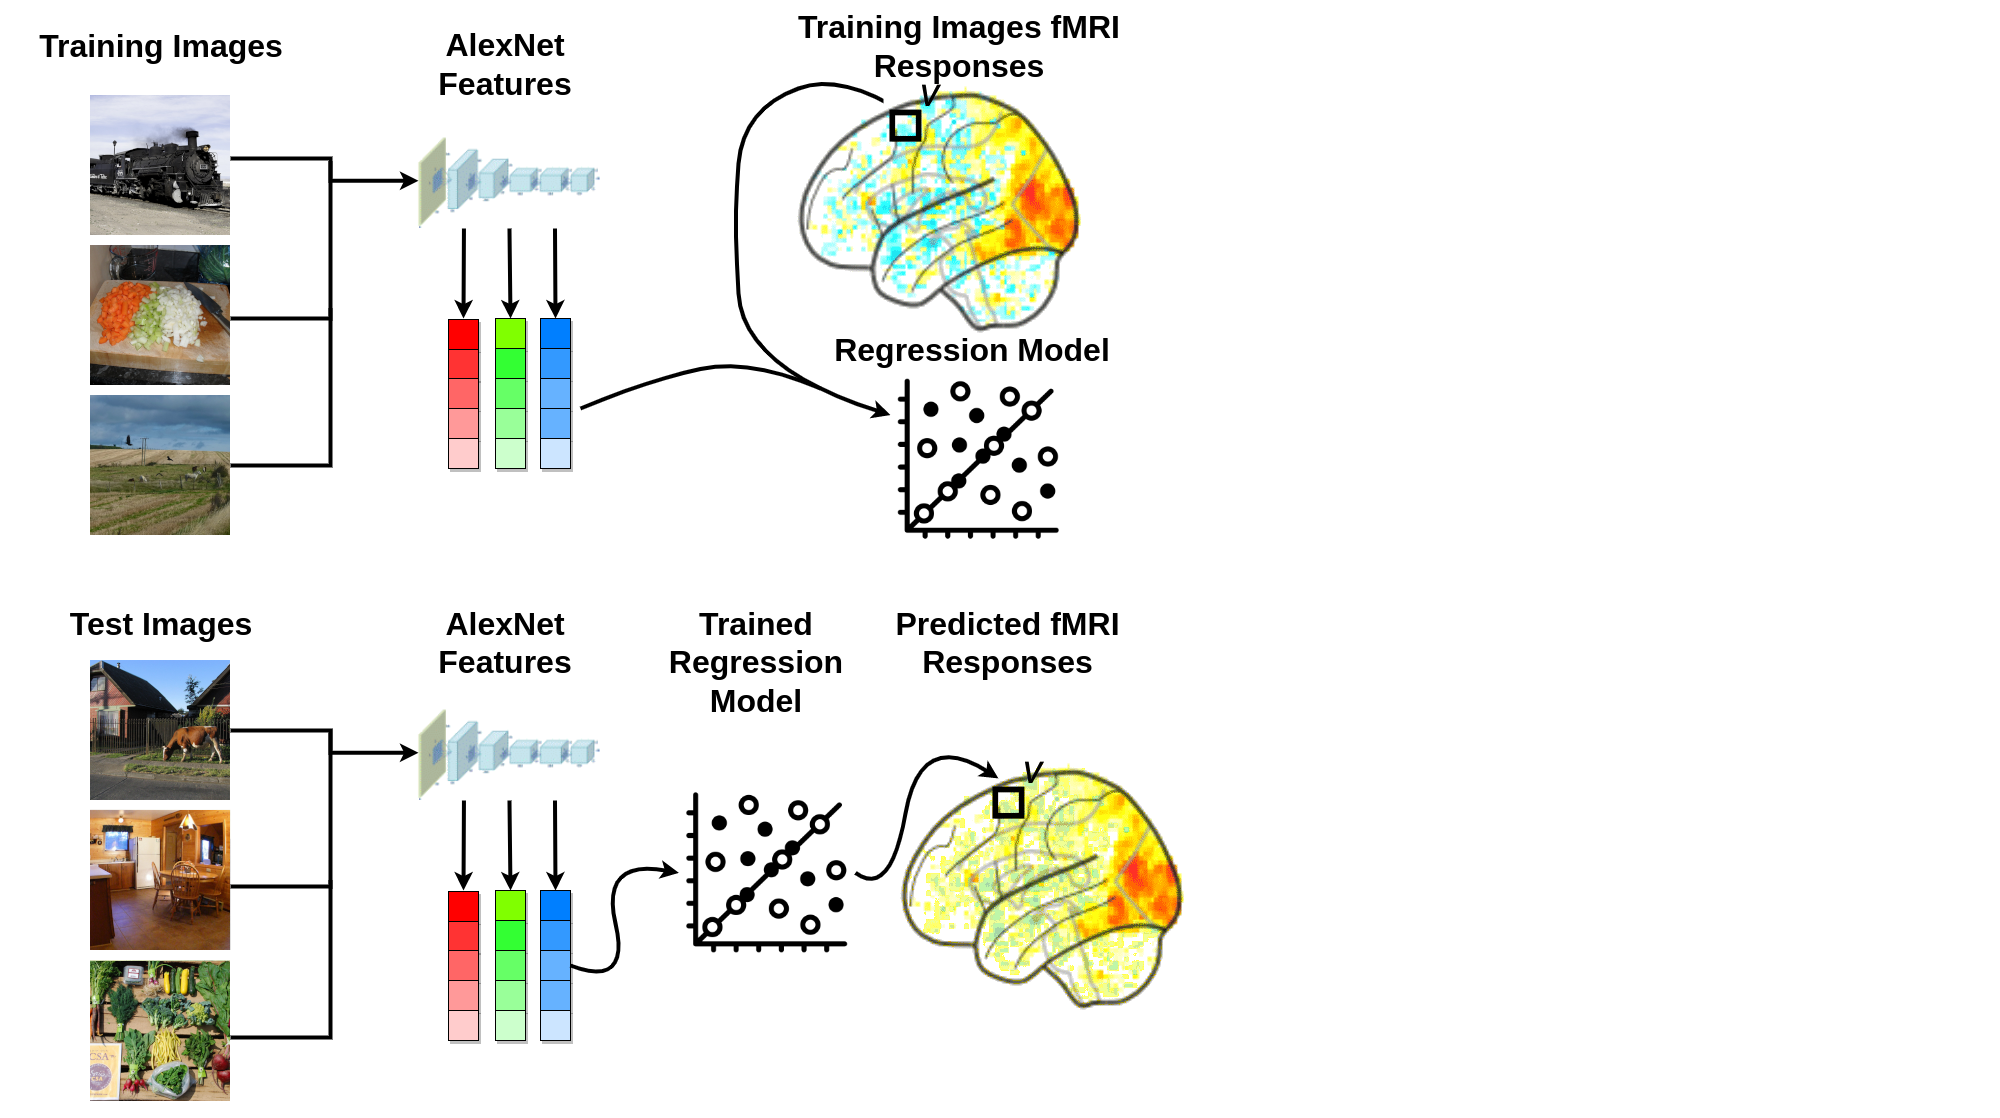

In [ ]:
# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)

## 2.4 Evaluate and visualize the encoding model's prediction accuracy (i.e., encoding accuracy) using the validation partition

### 2.4.1 Compute the encoding accuracy through a Pearson's correlation

Here you will compute your encoding model's prediction accuracy (or encoding accuracy) through a Pearson correlation between the predicted and ground truth fMRI validation partition data. The correlation scores indicate how similar the predicted fMRI data is to the ground truth data, namely how accurate your encoding model is in predicting (encoding) fMRI responses to images.

Specifically, you will correlate the activity of each predicted fMRI vertex with the activity of the corresponding ground truth fMRI vertex, across the validation partition stimulus images.

In [ ]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0] # 0 per selezionare valore e non p-value

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

100%|██████████| 20544/20544 [00:02<00:00, 7254.84it/s]


### 2.4.2 Visualize the encoding accuracy of all vertices on a brain surface map

We first visualize the encoding accuracy of all vertices on a brain surface map. For this we need to map each vertex of the correlation results (in `challenge space`) to the corresponding vertices on the brain surface template (in `fsaverage space`).

You need to choose the hemisphere (`'left'` or `'right'`) you want to visualize.

In [ ]:
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_correlation,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='Encoding accuracy, '+hemisphere+' hemisphere'
    )
view

### 2.4.3 Visualize the encoding accuracy of individual ROIs

Now we visualize the median encoding accuracy across the vertices of each ROI.

Note that not all ROIs exist for all subjects and hemispheres.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


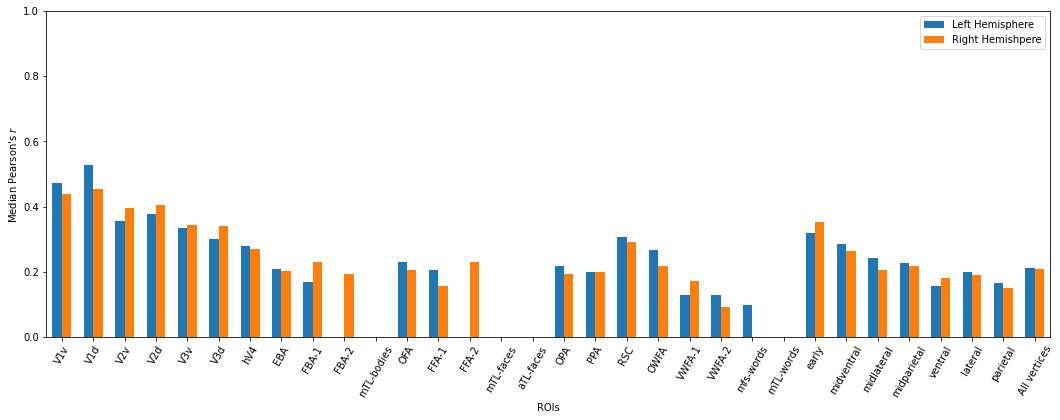

In [ ]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);

# 3 Prepare submission files

In this final section you will prepare the predicted brain responses to the test images in the right format for submission to [CodaLab][codalab].

First, you need to convert your predicted fMRI responses to `float32` data type. This is important, since the maximum submission size is 300MB, and a `float64` data type would exceed this limit.

[codalab]: https://codalab.lisn.upsaclay.fr/competitions/9304

In [ ]:
lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

Finally, save the predicted fMRI responses to the test images in the subject-specific submission directory that we created previously (`../algonauts_2023_challenge_submission/subj0X/`), where `'X'` goes from `'1'` to `'8'`), with separate files for the predictions of each hemisphere: `lh_pred_test.npy` for the left hemisphere and `rh_pred_test.npy` for the right hemisphere.

<font color='red'><b>NOTE:</b></font> these files need to contain the predicted brain responses of all vertices, and not of any ROI.

In [ ]:
np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)

After you save the predicted data of **all** subjects and hemispheres, zip the parent submission folder (`algonauts_2023_challenge_submission`) and submit it to [CodaLab][codalab]. Make sure that the files of all subjects and hemispheres are included in the right directory structure and with the right file and folder names, otherwise your submission will result in an error. [This video][codalab_video] goes over the CodaLab competition website layout, walks through an example submission, and explains the submission outputs.

<font color='red'><b>NOTE:</b></font> Naively zipping the `algonauts_2023_challenge_submission` folder can either create an extra parent folder, or remove the `subjXX` folders, both of which will mess up the filepaths and throw an error when submitting to CodaLab. To properly zip your folder from a file system browser, (1) enter the parent folder (`algonauts_2023_challenge_submission`), (2) highlight the 8 subject folders, and (3) zip. Alternatively, you can open your terminal and type:
```
cd ../algonauts_2023_challenge_submission
zip -r algonauts_2023_challenge_submission.zip ./
```

[codalab]: https://codalab.lisn.upsaclay.fr/competitions/9304
[codalab_video]: https://youtu.be/6b8OuMSXIpA

# Useful links

[Challenge Website][website]

[Challenge Paper][paper]

[Challenge Data][data]

[Challenge DevKit Tutorial (Colab)][tutorial_colab]

[Challenge DevKit Tutorial (GitHub)][tutorial_github]

[Challenge Overview and Colab Tutorial Walkthrough Video][challenge_video]

[CodaLab Challenge Submission Page][codalab]

[CodaLab Submission Walkthrough Video][codalab_video]

[Natural Scenes Dataset (NSD)][nsd]

[COCO Dataset][coco]

[Adapt COCO Metadata to Cropped NSD Images][adapt_coco_meta]

[website]: http://algonauts.csail.mit.edu
[paper]: https://arxiv.org/abs/2301.03198
[data]: https://docs.google.com/forms/d/e/1FAIpQLSehZkqZOUNk18uTjRTuLj7UYmRGz-OkdsU25AyO3Wm6iAb0VA/viewform?usp=sf_link
[tutorial_colab]: https://colab.research.google.com/drive/1bLJGP3bAo_hAOwZPHpiSHKlt97X9xsUw?usp=share_link
[tutorial_github]: https://github.com/gifale95/algonauts_2023
[challenge_video]: https://youtu.be/KlwSDpxUX6k
[codalab]: https://codalab.lisn.upsaclay.fr/competitions/9304
[codalab_video]: https://youtu.be/6b8OuMSXIpA
[nsd]: https://naturalscenesdataset.org/
[coco]: https://cocodataset.org/#home
[adapt_coco_meta]: https://github.com/styvesg/nsd_gnet8x/blob/main/data_preparation.ipynb

# Citations

If you use the data provided for the Algonauts Project 2023 Challenge please cite the following papers:
1. Gifford AT, Lahner B, Saba-Sadiya S, Vilas MG, Lascelles A, Oliva A, Kay K, Roig G, Cichy RM. 2023. *The Algonauts Project 2023 Challenge: How the Human Brain Makes Sense of Natural Scenes*. arXiv preprint, arXiv:2301.03198. DOI: https://doi.org/10.48550/arXiv.2301.03198

2. Allen EJ, St-Yves G, Wu Y, Breedlove JL, Prince JS, Dowdle LT, Nau M, Caron B, Pestilli F, Charest I, Hutchinson JB, Naselaris T, Kay K. 2022. *A massive 7T fMRI dataset to bridge cognitive neuroscience and computational intelligence*. Nature Neuroscience, 25(1):116–126. DOI: https://doi.org/10.1038/s41593-021-00962-x